In [1]:
import sqlalchemy
import pandas as pd
from IPython.display import HTML


from cg_analysis import (
    DB_URL,
    CG_COL_TYPES,
    CG_DATETYPE_COLS,
    LI_COL_TYPES,
    PT_COL_TYPES,
    PT_DATETYPE_COLS,
    FIN_COL_TYPES,
    FIN_DATETYPE_COLS,
    FIN_ADOPTION_COL_TYPES,
    DATA_PATH,
)
from cg_analysis import cg_query, li_query, fin_query, pt_query, fin_adoption_query

In [2]:
import importlib
import cg_analysis

importlib.reload(cg_analysis)

<module 'cg_analysis' from '/home/robyn/repositories/data-science/investigations/one-switch/cg_analysis.py'>

In [3]:
engine = sqlalchemy.create_engine(DB_URL)

# load carton grouping data
cg_df = pd.read_sql_query(
    sql=cg_query, con=engine, dtype=CG_COL_TYPES, parse_dates=CG_DATETYPE_COLS
)

# load line items data
li_df = pd.read_sql_query(sql=li_query, con=engine, dtype=LI_COL_TYPES)

# load pallet timeline data
pt_df = pd.read_sql_query(
    sql=pt_query,
    con=engine,
    dtype=PT_COL_TYPES,
    parse_dates=PT_DATETYPE_COLS,
)

# load finance data
fin_df = pd.read_sql_query(
    sql=fin_query,
    con=engine,
    dtype=FIN_COL_TYPES,
    parse_dates=FIN_DATETYPE_COLS,
)

# fin_adoption_df = pd.read_sql_query(
#     sql=fin_adoption_query,
#     con=engine,
#     dtype=FIN_ADOPTION_COL_TYPES,
# )
fin_adoption_df = pd.read_csv(
    DATA_PATH / "fin_adoption.csv",
    dtype=FIN_ADOPTION_COL_TYPES,
)

In [4]:
# Add std_cartons data

cg_df = cg_df.merge(
    pt_df[["cg_id", "std_cartons"]], left_on="id", right_on="cg_id", how="left"
)

# Data completeness


In [5]:
# Total carton groupings by data availability
cg_ids = set(cg_df["id"])

stats_df = pd.DataFrame(
    {
        "Category": [
            "Total Carton Groupings",
            "Orders Data Only",
            "Finance Data Only",
            "Both",
            "Neither",
        ],
        "Count": [
            len(cg_ids),
            len(
                set(
                    cg_df[
                        (cg_df["line_item_id"].notna())
                        & (~cg_df["id"].isin(fin_df["cg_id"]))
                    ]["id"]
                )
            ),
            len(
                set(
                    cg_df[
                        (cg_df["line_item_id"].isna())
                        & (cg_df["id"].isin(fin_df["cg_id"]))
                    ]["id"]
                )
            ),
            len(
                set(
                    cg_df[
                        (cg_df["line_item_id"].notna())
                        & (cg_df["id"].isin(fin_df["cg_id"]))
                    ]["id"]
                )
            ),
            len(
                set(
                    cg_df[
                        (cg_df["line_item_id"].isna())
                        & (~cg_df["id"].isin(fin_df["cg_id"]))
                    ]["id"]
                )
            ),
        ],
    }
)

# Add proportion column
stats_df["Proportion"] = (stats_df["Count"] / len(cg_ids) * 100).round(2)

# Display the DataFrame
print("\nTotal carton groupings by data availability")
display(stats_df)


Total carton groupings by data availability


,Category,Count,Proportion
0,Total Carton Groupings,826688,100.00
1,Orders Data Only,328496,39.74
2,Finance Data Only,141,0.02
3,Both,67777,8.20
4,Neither,430274,52.05


# Finance module adoption


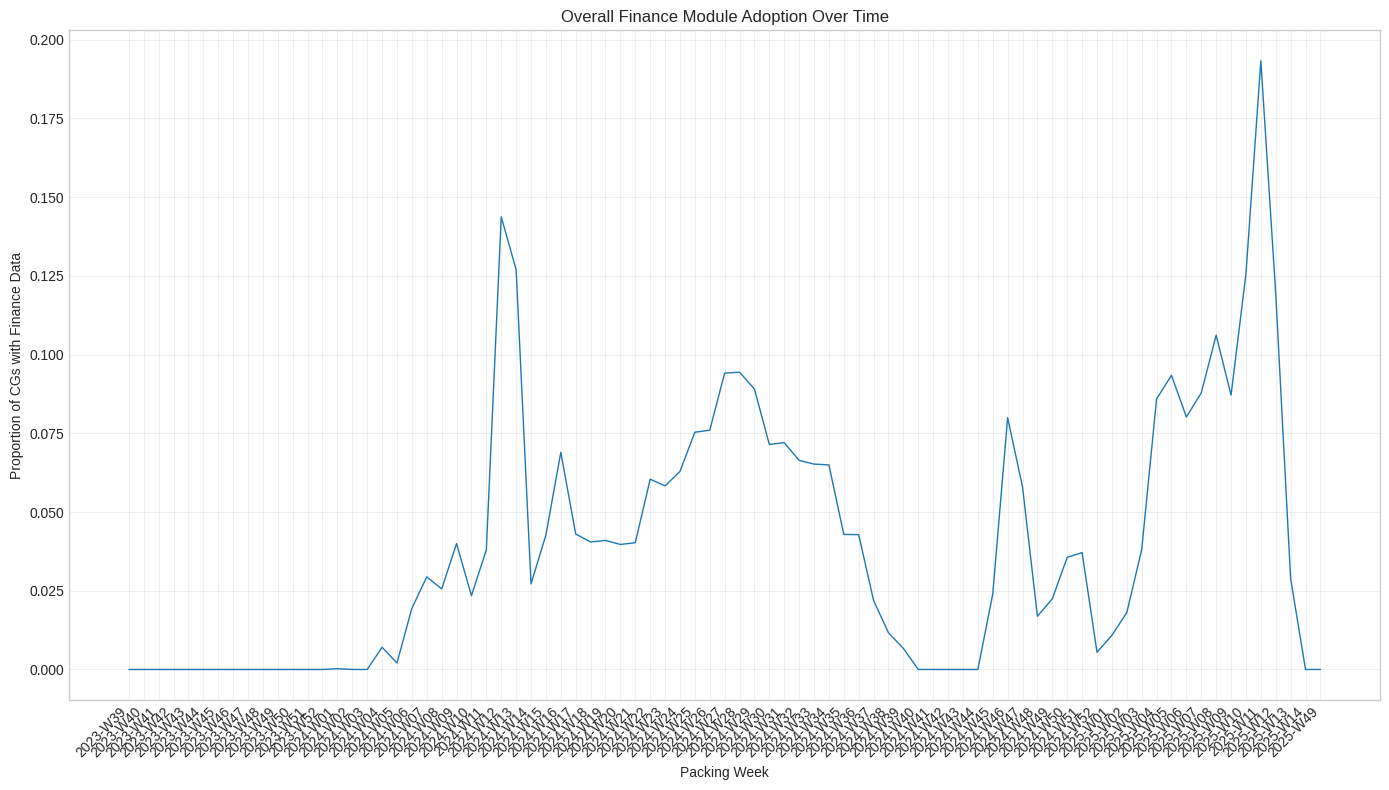

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Set the style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("colorblind")

# Aggregate the data by packing_week, summing finance_cgs and total_cgs across all commodity groups
agg_data = (
    fin_adoption_df.groupby("packing_week")
    .agg({"finance_cgs": "sum", "total_cgs": "sum"})
    .reset_index()
)

# Calculate the proportion
agg_data["adoption_rate"] = agg_data["finance_cgs"] / agg_data["total_cgs"]

# Create a figure with appropriate size
plt.figure(figsize=(14, 8))

# Plot the data with thinner lines and no markers
plt.plot(
    agg_data["packing_week"], agg_data["adoption_rate"], linewidth=1.0, color="#1f77b4"
)

# Set smaller font sizes for title and axis labels
plt.title("Overall Finance Module Adoption Over Time", fontsize=12)
plt.xlabel("Packing Week", fontsize=10)
plt.ylabel("Proportion of CGs with Finance Data", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 1400x800 with 0 Axes>

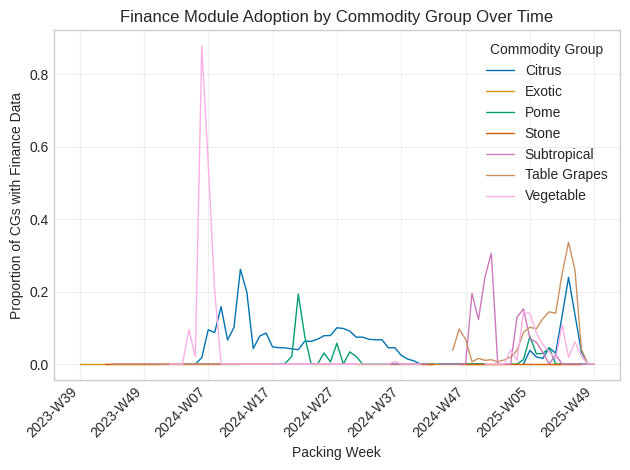

In [14]:
import seaborn as sns

# Set the style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("colorblind")

# Create a figure with appropriate size
plt.figure(figsize=(14, 8))

# Pivot the data for plotting
pivot_df = fin_adoption_df.pivot(
    index="packing_week", columns="commodity_group", values="prop_finance_cgs"
)

# Plot the data with thinner lines and no markers
ax = pivot_df.plot(kind="line", marker=None, linewidth=1.0)

# Set smaller font sizes for title and axis labels
plt.title("Finance Module Adoption by Commodity Group Over Time", fontsize=12)
plt.xlabel("Packing Week", fontsize=10)
plt.ylabel("Proportion of CGs with Finance Data", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)

# Add legend outside the plot area
plt.legend(
    title="Commodity Group", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9
)
plt.legend().set_title("Commodity Group", prop={"size": 10})

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
cg_df_copy = cg_df[
    [
        "id",
        "line_item_id",
        "commodity_name",
        "variety_name",
        "production_region",
        "seller_id",
        "buyer_id",
        "local_market",
        "target_country",
        "packing_week",
        "pallet_number",
        "cartons",
        "std_cartons",
    ]
]
li_df_copy = li_df[
    ["id", "quantity", "quantity_unit", "price_minor_unit", "price_unit", "currency"]
]

In [16]:
import numpy as np

price_df = cg_df_copy.merge(
    li_df_copy,
    left_on="line_item_id",
    right_on="id",
    how="left",
    suffixes=("_cg", "_li"),
)
# Import numpy if not already imported
import numpy as np

price_df.replace("None", np.nan, inplace=True)

In [17]:
# For price analysis
# 1. Count of carton groupings with non-null price data (all three fields)
price_complete = (
    price_df["price_unit"].notna()
    & price_df["price_minor_unit"].notna()
    & price_df["currency"].notna()
)
price_complete_count = price_complete.sum()
total_cgs = len(price_df)

print(
    f"Out of {total_cgs} carton groupings, {price_complete_count} ({price_complete_count/total_cgs*100:.2f}%) have non-null values for price_unit, price_minor_unit, and currency"
)

# 2. Unique values of price_unit and their percentage breakdown
price_unit_counts = price_df["price_unit"].value_counts(dropna=False)
price_unit_percentages = (
    price_df["price_unit"].value_counts(normalize=True, dropna=False) * 100
)

print("\nPrice unit breakdown:")
for unit, count in price_unit_counts.items():
    percentage = price_unit_percentages[unit]
    unit_display = "NaN" if pd.isna(unit) else unit
    print(f"  {unit_display}: {count} ({percentage:.2f}%)")

# 3. Unique values of currency
currency_counts = price_df["currency"].value_counts(dropna=False)

print("\nCurrency breakdown:")
for currency, count in currency_counts.items():
    percentage = count / total_cgs * 100
    currency_display = "NaN" if pd.isna(currency) else currency
    print(f"  {currency_display}: {count} ({percentage:.2f}%)")

# For quantity analysis
# 1. Count of carton groupings with non-null quantity_unit and quantity
quantity_complete = price_df["quantity_unit"].notna() & price_df["quantity"].notna()
quantity_complete_count = quantity_complete.sum()

print(
    f"\nOut of {total_cgs} carton groupings, {quantity_complete_count} ({quantity_complete_count/total_cgs*100:.2f}%) have both non-null quantity_unit and quantity values"
)

# 2. Unique values of quantity_unit and their percentage breakdown
quantity_unit_counts = price_df["quantity_unit"].value_counts(dropna=False)
quantity_unit_percentages = (
    price_df["quantity_unit"].value_counts(normalize=True, dropna=False) * 100
)

print("\nQuantity unit breakdown:")
for unit, count in quantity_unit_counts.items():
    percentage = quantity_unit_percentages[unit]
    unit_display = "NaN" if pd.isna(unit) else unit
    print(f"  {unit_display}: {count} ({percentage:.2f}%)")

# NEW: Count carton groupings with ALL mentioned columns having non-null values
all_complete = price_complete & quantity_complete
all_complete_count = all_complete.sum()

print(
    f"\nOut of {total_cgs} carton groupings, {all_complete_count} ({all_complete_count/total_cgs*100:.2f}%) have non-null values for ALL mentioned columns (price_unit, price_minor_unit, currency, quantity_unit, and quantity)"
)

Out of 826688 carton groupings, 395918 (47.89%) have non-null values for price_unit, price_minor_unit, and currency

Price unit breakdown:
  NaN: 430770 (52.11%)
  carton: 376191 (45.51%)
  ton: 19727 (2.39%)

Currency breakdown:
  NaN: 430415 (52.06%)
  USD: 201994 (24.43%)
  EUR: 145846 (17.64%)
  ZAR: 37768 (4.57%)
  GBP: 5241 (0.63%)
  CAD: 2352 (0.28%)
  JPY: 1577 (0.19%)
  CNY: 1495 (0.18%)

Out of 826688 carton groupings, 284432 (34.41%) have both non-null quantity_unit and quantity values

Quantity unit breakdown:
  NaN: 468913 (56.72%)
  pallet: 355188 (42.97%)
  carton: 1983 (0.24%)
  container: 604 (0.07%)

Out of 826688 carton groupings, 284277 (34.39%) have non-null values for ALL mentioned columns (price_unit, price_minor_unit, currency, quantity_unit, and quantity)


# Finance data inference

## Line items

Out of 826,688 carton groupings, 284,277 (34%) have non-null values for columns `price_unit`, `price_minor_unit`, `currency`, `quantity_unit`, and `quantity` (in `line_items`)

**Would these price and quantity values be a suitable estimate for 'finance' data - i.e. are they a good estimate for what a buyer would have actually paid**

## Future analysis

1. Compare invoice data in `dso_finance` with `line_items` fields to determine whether `line_items` is a good estimator for finance data?
